In [175]:
import re
import random
import pandas as pd
import hashlib

In [176]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [177]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'mean'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
"Mexican Gothic, Moreno-Garcia",67.863744,2.423705,9.159449,28
Azure Functions Core Tools,126.139434,7.419967,20.896775,17
OAuth 2.0 RFC6749,95.512107,23.878027,26.296132,4
Node.js and Vite,1038.964219,25.340591,48.162695,41
Django,1059.389177,26.484729,39.120755,40
Azure Files Documentation,2301.516429,38.358607,130.462727,60
FSLogix,128.040847,42.680282,50.439771,3
Active Directory and Azure Files,1743.027416,47.108849,88.013238,37
CCH Tax Forms Project,997.552127,47.502482,115.742307,21
Python + Oauth2.0,1313.245223,57.097618,129.274338,23


# Histogram

sum of ages: ~52375.52


<Axes: >

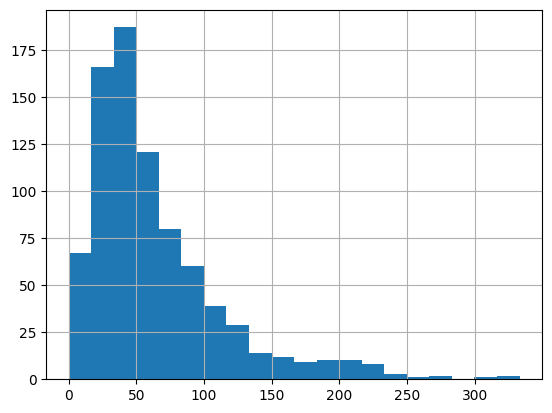

In [178]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~52375.52


<Axes: >

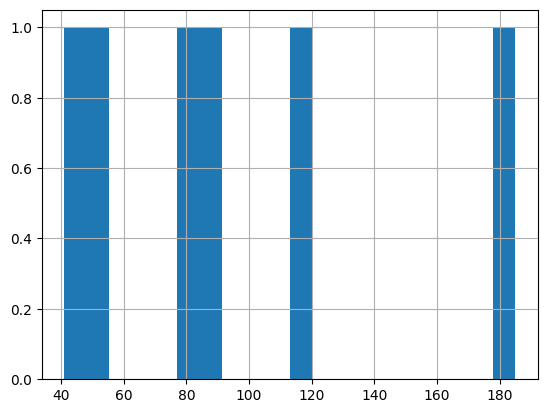

In [179]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='VMWare']['age'].hist(bins=20)

# Completely Random Shuffle

In [180]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [181]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [182]:
# n = 3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [183]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [184]:
n = 5
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

if existing_cards['age'].sum() > 0:
    existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# existing_cards.sort_values(['age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 821
Total card age: 52375.52


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
0,TSQL,Stored Procedures:\n\nPrecompiled TSQL routine...,1c1c29f98d6c0bd8774d3c31bfcdd3e4,333.200707,83.562338,-333.200707,2005.496103,0.037182,24,0,0,-333.200707
1,TSQL,Column and Table Aliasing:\n\nUse the AS keywo...,b2d566df6211f9f8dfb6e5a7760dec96,141.837597,83.562338,-333.200707,2005.496103,0.037182,24,1,0,-141.837597
3,TSQL,"Q: Why would you use COALESCE(a, b) in a SELEC...",9599c71bb44aa9c23eca4cb094d34e63,113.550682,83.562338,-333.200707,2005.496103,0.037182,24,2,0,-113.550682
2,TSQL,Subqueries:\n\nQueries nested within other que...,387d43697fcfe93769616f5775b954c0,110.786501,83.562338,-333.200707,2005.496103,0.037182,24,3,0,-110.786501
127,TSQL,Temporary Tables:\n\nCreated with a hash (#) p...,abb2b766275c2aaa389f749f4c957071,106.423314,83.562338,-333.200707,2005.496103,0.037182,24,4,0,-106.423314
5,Terraform Codebox,Process segmentation fault (Segmentation fault...,e4cf055569f377aaeff23124919e4d27,317.701280,81.801483,-317.701280,4008.272646,0.301711,49,0,0,-317.701280
6,Terraform Codebox,Terraform Registry is where official and commu...,5aeeebf71219ff35da683979c85ed7aa,237.121296,81.801483,-317.701280,4008.272646,0.301711,49,1,0,-237.121296
7,Terraform Codebox,A cloud-init.yaml.tpl file is a template for p...,e86be4b765ffee839b385a1a96ac3db1,222.780820,81.801483,-317.701280,4008.272646,0.301711,49,2,0,-222.780820
8,Terraform Codebox,Azure Files can be used to persist your coding...,9775a34a34e3610d8ddc43c1e0b44268,212.117629,81.801483,-317.701280,4008.272646,0.301711,49,3,0,-212.117629
9,Terraform Codebox,Out of Memory (OOM) condition\nOccurs when a V...,c531b35b8ce0b73612d57b26a4e8c0ff,170.455950,81.801483,-317.701280,4008.272646,0.301711,49,4,0,-170.455950


## Card Count

In [185]:
# n=5
# # existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [186]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [187]:
existing_cards.head(10)['age'].sum()

np.float64(1965.9757763605146)

In [188]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
0,TSQL,Stored Procedures:\n\nPrecompiled TSQL routine...,1c1c29f98d6c0bd8774d3c31bfcdd3e4,333.200707,83.562338,-333.200707,2005.496103,0.037182,24,0,0,-333.200707
5,Terraform Codebox,Process segmentation fault (Segmentation fault...,e4cf055569f377aaeff23124919e4d27,317.701280,81.801483,-317.701280,4008.272646,0.301711,49,0,0,-317.701280
10,PnP PowerShell,PSCredential (Microsoft.PowerShell.Security)\n...,58979b94f2077e07481d767d7e748fc9,304.894601,91.499082,-304.894601,3293.966953,0.980993,36,0,0,-304.894601
15,Python,Q:\nHow can you measure the performance of a g...,13eda1c228af6c0fae5fc403983fa80e,276.617934,71.262579,-276.617934,5059.643114,0.095609,71,0,0,-276.617934
20,Power BI,"Q: In a Pro workspace, which Service-side feat...",25b487580bae6b89adcd0c6909e8aa20,270.632806,75.811927,-270.632806,2501.793591,0.944300,33,0,0,-270.632806
25,Azure Compute Gallery,One Compute Gallery Per Subscription – ACG is ...,7b7b4f84c6bc6891a0e1e7cf19f2922e,265.906216,96.976980,-265.906216,1939.539603,0.494557,20,0,0,-265.906216
6,Terraform Codebox,Terraform Registry is where official and commu...,5aeeebf71219ff35da683979c85ed7aa,237.121296,81.801483,-317.701280,4008.272646,0.301711,49,1,0,-237.121296
30,JavaScript Concepts,Reserved Words: Identifiers cannot be the same...,042a95e59a28c2e0d94382aacc1a1751,236.602658,74.540500,-236.602658,3801.565493,0.369899,51,0,0,-236.602658
35,CCH Axcess,Client IDs can have up to 15 characters and ca...,220856831fa9fb7a8c1022a5ce48fb6d,235.411855,79.980200,-235.411855,4718.831789,0.819957,59,0,0,-235.411855
40,Azure VM + Developer,Port Forwarding\nAn SSH feature that lets you ...,ab24eca09d42d7293e8d28293893ab14,231.624747,95.566737,-231.624747,2198.034950,0.345189,23,0,0,-231.624747


In [189]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 63.795'